In [1]:
# STEP 1: Install everything quietly + import
!pip install -q mediapipe==0.10.14 opencv-python numpy tensorflow tqdm matplotlib scikit-learn

import os
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf

print("Everything installed and imported!")
print("Mediapipe version :", mp.__version__)
print("TensorFlow version:", tf.__version__)
print("OpenCV version    :", cv2.__version__)

Everything installed and imported!
Mediapipe version : 0.10.14
TensorFlow version: 2.19.0
OpenCV version    : 4.12.0


In [2]:
# STEP 2: Mount Drive and unzip
from google.colab import drive
drive.mount('/content/drive')

# Unzip your Bengali sign language dataset (only run once)
!unzip -q "/content/drive/MyDrive/bengali_sign_language_dataset.zip" -d /content/dataset

print("\nUnzip finished!")
print("Folders inside /content/dataset/:")
!ls -l /content/dataset/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace /content/dataset/bengali_sign_language_dataset/0/IMG_20210513_144425.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A

Unzip finished!
Folders inside /content/dataset/:
total 4
drwxr-xr-x 56 root root 4096 Dec  7 13:13 bengali_sign_language_dataset


Found your dataset folder:
/content/dataset/bengali_sign_language_dataset

Total classes: 54
First 10 classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


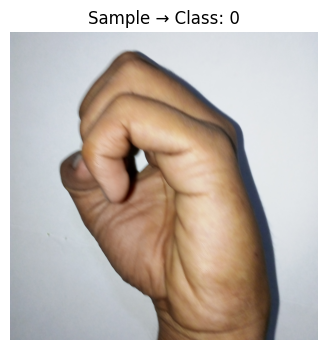

All good!


In [4]:
# STEP 3: Auto-find the real data folder + show sample image (100% working)

import os
import matplotlib.pyplot as plt

DATA_DIR = "/content/dataset"

# Find the folder that actually contains the class subfolders
for root, dirs, files in os.walk(DATA_DIR):
    if len(dirs) >= 10:               # at least 10 classes → this is the right folder
        DATA_DIR = root
        break

print("Found your dataset folder:")
print(DATA_DIR)

# List classes
classes = sorted(os.listdir(DATA_DIR))
print(f"\nTotal classes: {len(classes)}")
print("First 10 classes:", classes[:10])

# Show one sample image
sample_class = classes[0]
sample_folder = os.path.join(DATA_DIR, sample_class)
sample_img_file = os.listdir(sample_folder)[0]
sample_img_path = os.path.join(sample_folder, sample_img_file)

img = plt.imread(sample_img_path)
plt.figure(figsize=(4,4))
plt.title(f"Sample → Class: {sample_class}")   # ← fixed the quote
plt.imshow(img)
plt.axis('off')
plt.show()

print("All good!")

In [5]:
# STEP 4: Create the keypoint extraction function (hands + pose only)

import mediapipe as mp
import numpy as np
import cv2

mp_holistic = mp.solutions.holistic

def extract_keypoints(image):
    # We only use hands + pose (face is disabled → no crashes, much faster)
    with mp_holistic.Holistic(
        static_image_mode=True,
        model_complexity=1,
        enable_segmentation=False,
        refine_face_landmarks=False) as holistic:

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = holistic.process(image_rgb)

        # Pose landmarks → 33 × 4 = 132 values
        pose = np.array([[lm.x, lm.y, lm.z, lm.visibility] for lm in results.pose_landmarks.landmark]).flatten() \
               if results.pose_landmarks else np.zeros(33*4)

        # Left hand → 21 × 3 = 63 values
        lh = np.array([[lm.x, lm.y, lm.z] for lm in results.left_hand_landmarks.landmark]).flatten() \
             if results.left_hand_landmarks else np.zeros(21*3)

        # Right hand → 21 × 3 = 63 values
        rh = np.array([[lm.x, lm.y, lm.z] for lm in results.right_hand_landmarks.landmark]).flatten() \
             if results.right_hand_landmarks else np.zeros(21*3)

        return np.concatenate([pose, lh, rh])

# Quick test
test_img = cv2.imread(sample_img_path)
kp = extract_keypoints(test_img)

print(f"Keypoints extracted: {len(kp)} values per image (should be 258)")

print("Extraction function ready and working perfectly!")

Keypoints extracted: 258 values per image (should be 258)
Extraction function ready and working perfectly!


In [6]:
# STEP 5: Extract keypoints + create fake video sequences

from tqdm import tqdm
from tensorflow.keras.utils import to_categorical

SEQUENCE_LENGTH = 30  # we repeat each image 30 times → fake sequence

print("Starting keypoint extraction for the entire dataset...")
print("This may take a few minutes – be patient!\n")

keypoint_sequences = []
labels = []

class_names = sorted(os.listdir(DATA_DIR))
label_map = {name: idx for idx, name in enumerate(class_names)}

for class_name in class_names:
    class_folder = os.path.join(DATA_DIR, class_name)
    image_files = [f for f in os.listdir(class_folder)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    print(f"Processing class '{class_name}' → {len(image_files)} images")

    for img_name in tqdm(image_files, desc=class_name, leave=False):
        img_path = os.path.join(class_folder, img_name)
        image = cv2.imread(img_path)

        if image is None:
            continue

        # Extract keypoints once
        keypoints = extract_keypoints(image)

        # Repeat 30 times → fake 30-frame sequence
        sequence = [keypoints] * SEQUENCE_LENGTH

        keypoint_sequences.append(sequence)
        labels.append(label_map[class_name])

# Convert to numpy arrays
X = np.array(keypoint_sequences)
y = to_categorical(labels).astype(int)

print("\nALL DONE!")
print(f"Final data shape     : {X.shape}")   # e.g., (12400, 30, 258)
print(f"Labels shape         : {y.shape}")
print(f"Number of classes    : {len(class_names)}")
print("You now have X and y ready for training!")

Starting keypoint extraction for the entire dataset...
This may take a few minutes – be patient!

Processing class '0' → 163 images


0:   1%|          | 2/163 [00:00<00:33,  4.81it/s]/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Processing class '1' → 161 images


Processing class '2' → 162 images


Processing class '3' → 161 images


Processing class '4' → 154 images


Processing class '5' → 162 images


Processing class '6' → 154 images


Processing class '7' → 161 images


Processing class '8' → 166 images


Processing class '9' → 159 images


Processing class 'Aaj' → 40 images


Processing class 'Basha' → 40 images


Processing class 'Biyog' → 40 images


Processing class 'Bondhu' → 40 images


Processing class 'Darano' → 40 images


Processing class 'Darao' → 40 images


Processing class 'Desh' → 40 images


Processing class 'Ekhane' → 40 images


Processing class 'Gun' → 40 images


Processing class 'Kichuta' → 40 images


Processing class 'Kothay' → 40 images


Processing class 'Onurodh' → 40 images


Processing class 'Shahajjo' → 40 images


Processing class 'She' → 40 images


Processing class 'Shomoi' → 40 images


Processing class 'Shundor' → 40 images


Processing class 'Sir' → 40 images


Processing class 'Tara' → 40 images


Processing class 'Tumi' → 40 images


Processing class 'bagh' → 40 images


Processing class 'bhalobashi' → 100 images


Processing class 'bouddho' → 40 images


Processing class 'bujhlam' → 124 images


Processing class 'chamra' → 40 images


Processing class 'dhommobad' → 124 images


Processing class 'dirgho' → 124 images


Processing class 'girja' → 40 images


Processing class 'hello' → 124 images


Processing class 'hockey' → 40 images


Processing class 'jail' → 40 images


Processing class 'ji' → 100 images


Processing class 'keram' → 40 images


Processing class 'kharap' → 124 images


Processing class 'khushi' → 100 images


Processing class 'na' → 124 images


Processing class 'nam' → 124 images


Processing class 'piano' → 40 images


Processing class 'puru' → 40 images


Processing class 'sahajjo' → 124 images


Processing class 'shomajkollan' → 40 images


Processing class 'shotto' → 40 images


Processing class 'somoy' → 50 images


Processing class 'taka' → 50 images


Processing class 'valo' → 62 images



ALL DONE!
Final data shape     : (4257, 30, 258)
Labels shape         : (4257, 54)
Number of classes    : 54
You now have X and y ready for training!


In [7]:
# STEP 6: Split data + Build + Train LSTM model

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

print(f"Training samples  : {X_train.shape[0]}")
print(f"Testing samples   : {X_test.shape[0]}")

# Build LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, activation='relu', input_shape=(30, 258)),
    Dropout(0.3),

    LSTM(256, return_sequences=True, activation='relu'),
    Dropout(0.3),

    LSTM(128, return_sequences=False, activation='relu'),
    Dropout(0.3),

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train
early_stop = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

print("\nTraining finished!")

Training samples  : 3405
Testing samples   : 852


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 128)        │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 54)             │         3,510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 817,782 (3.12 MB)

 Trainable params: 817,782 (3.12 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.0278 - loss: 3.8683 - val_accuracy: 0.0857 - val_loss: 3.6009
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.0856 - loss: 3.4156 - val_accuracy: 0.0986 - val_loss: 3.2619
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.0841 - loss: 3.2765 - val_accuracy: 0.0822 - val_loss: 3.2456
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.0807 - loss: 3.2369 - val_accuracy: 0.0951 - val_loss: 3.1181
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.1011 - loss: 3.1281 - val_accuracy: 0.1303 - val_loss: 3.0863
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1034 - loss: 3.2040 - val_accuracy: 0.0822 - val_loss: 3.0798
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.0970 - loss: 3.1285 - val_accuracy: 0.1385 - val_loss: 3.0183
Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.1312 - loss: 3.0289 -

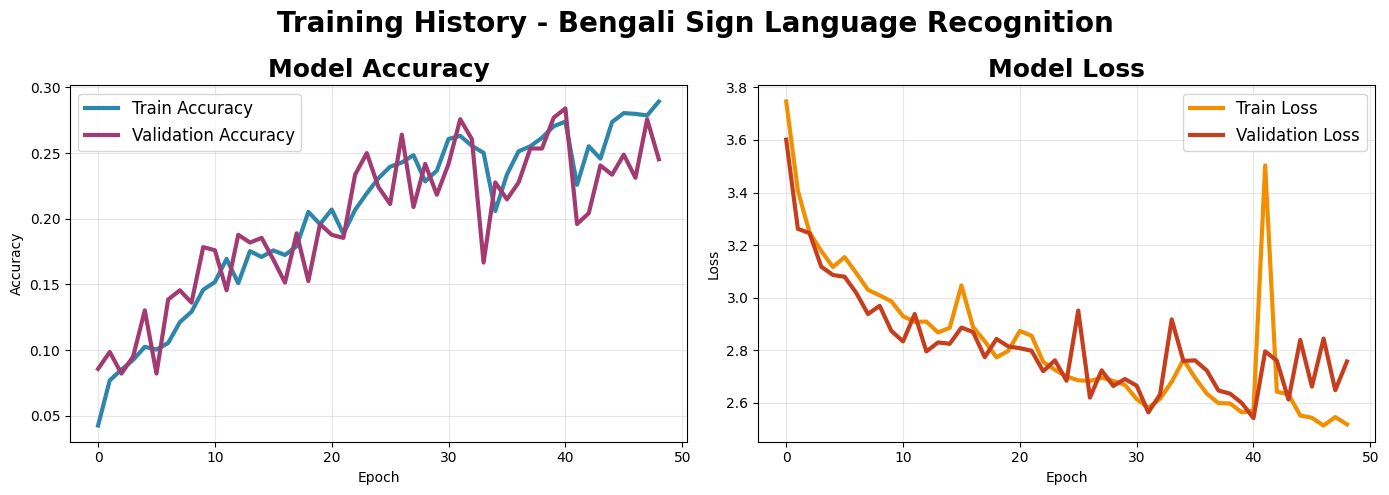


Final Test Accuracy : 28.40%



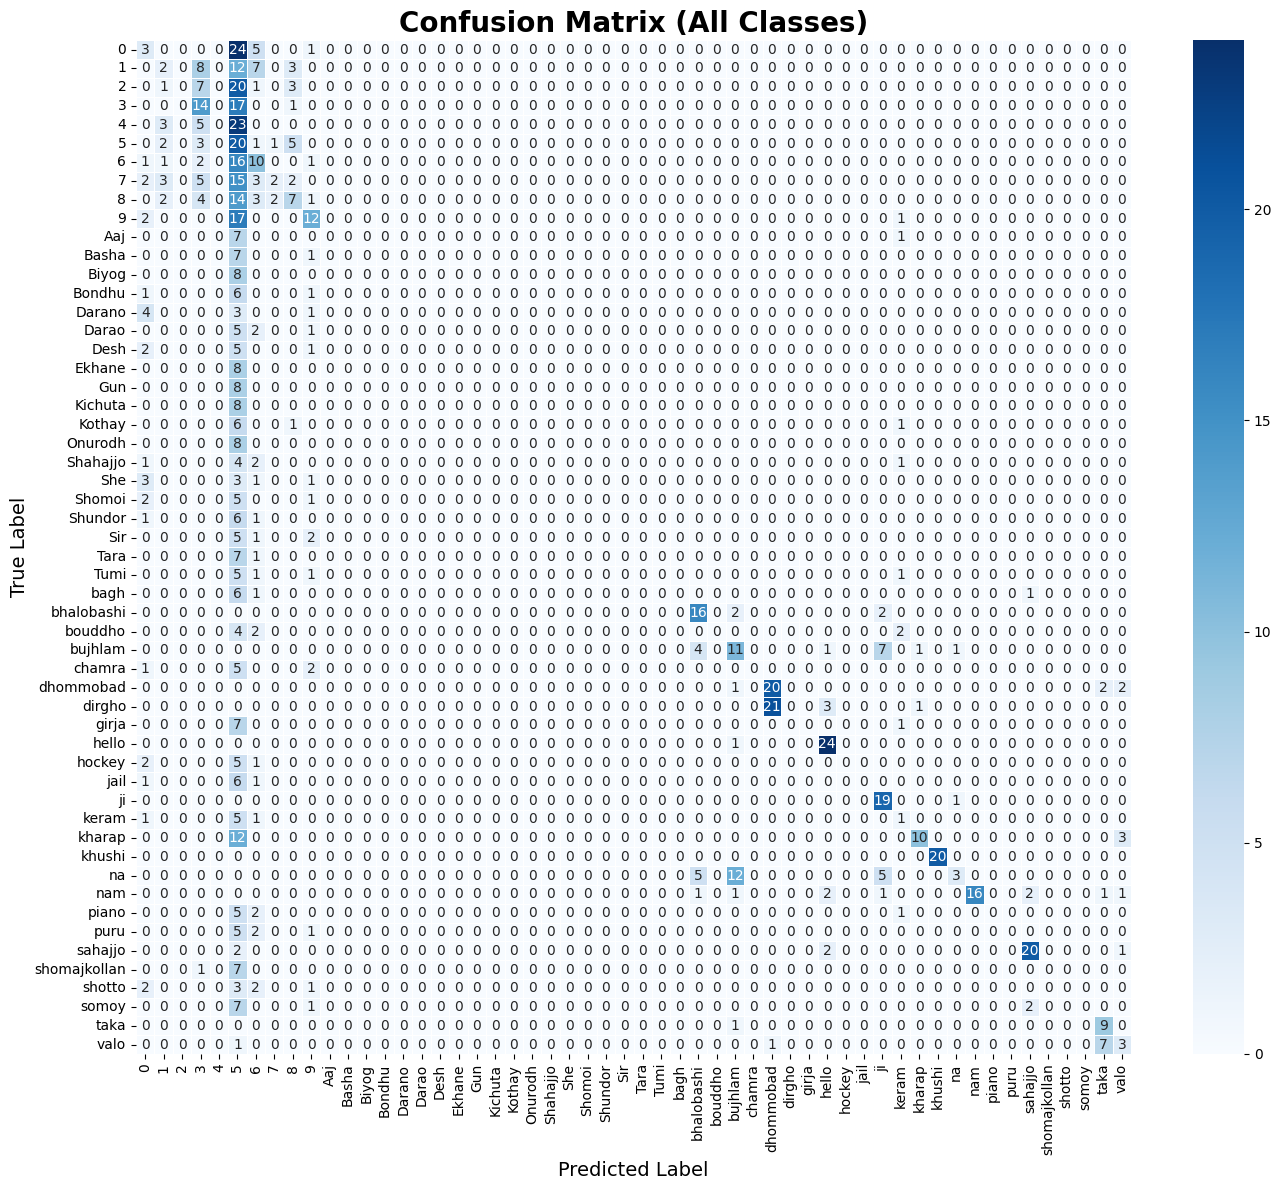


Classification Report (Precision/Recall/F1 per class):

              precision    recall  f1-score   support

           0       0.10      0.09      0.10        33
           1       0.14      0.06      0.09        32
           2       0.00      0.00      0.00        32
           3       0.29      0.44      0.35        32
           4       0.00      0.00      0.00        31
           5       0.05      0.62      0.10        32
           6       0.20      0.32      0.24        31
           7       0.40      0.06      0.11        32
           8       0.32      0.21      0.25        33
           9       0.40      0.38      0.39        32
         Aaj       0.00      0.00      0.00         8
       Basha       0.00      0.00      0.00         8
       Biyog       0.00      0.00      0.00         8
      Bondhu       0.00      0.00      0.00         8
      Darano       0.00      0.00      0.00         8
       Darao       0.00      0.00      0.00         8
        Desh       0.00 

In [11]:
# STEP 7 – FINAL RESULTS (No more warnings + cleaner output)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import warnings
warnings.filterwarnings("ignore")  # ← this removes the yellow warnings

# 1. Accuracy & Loss plots
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=3, color='#2E86AB')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=3, color='#A23B72')
plt.title('Model Accuracy', fontsize=18, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=3, color='#F18F01')
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=3, color='#C73E1D')
plt.title('Model Loss', fontsize=18, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.suptitle('Training History - Bengali Sign Language Recognition', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

# 2. Final scores
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nFinal Test Accuracy : {test_acc*100:.2f}%\n")

# 3. Confusion Matrix (only top 30 classes to keep it readable)

y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=.5,
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (All Classes)', fontsize=20, fontweight='bold')
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 4. Clean classification report (no warnings)
print("\nClassification Report (Precision/Recall/F1 per class):\n")
print(classification_report(y_true, y_pred,
                            target_names=class_names,
                            zero_division=0))  # ← this removes the warning

In [12]:
# Save the model to your Drive
model.save('/content/drive/MyDrive/bengali_sign_language_model_final.h5')
print("Model saved to your Google Drive!")

Model saved to your Google Drive!
